# Arrest data in NYC, an exploration and regression analysis
## Author: Jack Robbins

In [1]:
# Important imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn import preprocessing
from matplotlib.gridspec import GridSpec

In [2]:
# Read in our dataframe
arrests = pd.read_csv("data/NYPD_Arrests_Data__Historic__20241018.csv")

In [3]:
# Let's see what we're working with
arrests.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,186134240,08/07/2018,184.0,NaN,NaN,NaN,PL 12070E1,F,K,73,0.0,45-64,M,BLACK,1007585.0,183788.0,40.671110,-73.915881,POINT (-73.91588130999997 40.67110980800004)
1,220476154,11/13/2020,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 1600500,F,B,40,0.0,25-44,M,BLACK,1005041.0,234533.0,40.810398,-73.924895,POINT (-73.92489531099994 40.810398494000026)
2,199148493,07/01/2019,440.0,NaN,NaN,NaN,PL 1553502,F,M,23,1.0,25-44,M,BLACK HISPANIC,998829.0,226859.0,40.789348,-73.947352,POINT (-73.94735241299998 40.78934789300007)
3,209928408,02/22/2020,569.0,"MARIJUANA, SALE 4 & 5",235.0,DANGEROUS DRUGS,PL 2214000,M,M,32,0.0,25-44,M,BLACK,1001610.0,241367.0,40.829163,-73.937272,POINT (-73.93727189399993 40.829163304000076)
4,220330574,11/10/2020,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,B,49,0.0,25-44,M,WHITE,1024396.0,250744.0,40.854826,-73.854880,POINT (-73.85487970999998 40.85482622300003)


## Data Preprocessing
As we can see from above, we have a lot of NULLs and data that we may or may not want. We'll clean this data up before doing anything involving data analysis.

In [4]:
null_values=arrests.isnull().sum()
print("Detecting missing values:\n", null_values)

Detecting missing values:
 ARREST_KEY               0
ARREST_DATE              0
PD_CD                  876
PD_DESC               9169
KY_CD                 9756
OFNS_DESC             9169
LAW_CODE               196
LAW_CAT_CD           23600
ARREST_BORO              8
ARREST_PRECINCT          0
JURISDICTION_CODE       10
AGE_GROUP               17
PERP_SEX                 0
PERP_RACE                0
X_COORD_CD               1
Y_COORD_CD               1
Latitude                 1
Longitude                1
Lon_Lat                  1
dtype: int64


### Unneeded columns
Looking here, we have a column titled "ARREST KEY" which is likely the primary key for the database where this is stored. We don't need this column and therefore will drop it. We also don't need "LON_LAT" as it is just a combination of two other columns. The same can be said for X_COORD_CD and Y_COORD_CD, because these are just proxies for longitutde and latitute. Offense description is a free entry text field, and likely to contain large amounts of junk in it with no consistent pattern, so we'll get rid of that as well.

In [5]:
# Dropping columns
arrests.drop(['ARREST_KEY', 'X_COORD_CD', 'Y_COORD_CD',\
                 'OFNS_DESC','PD_DESC','Lon_Lat', 'Latitude', 'Longitude'], axis=1, inplace=True)

In [6]:
# Let's see how w're looking now
null_values=arrests.isnull().sum()
print("Detecting missing values:\n", null_values)

Detecting missing values:
 ARREST_DATE              0
PD_CD                  876
KY_CD                 9756
LAW_CODE               196
LAW_CAT_CD           23600
ARREST_BORO              8
ARREST_PRECINCT          0
JURISDICTION_CODE       10
AGE_GROUP               17
PERP_SEX                 0
PERP_RACE                0
dtype: int64


In [7]:
arrests.shape

(5725522, 11)

### Removing NA's
As we can see, we have nearly 6 million rows of data to work with here. Additionally, there are only at most around 40,000 NA's in the dataset. In my opinion, dropping these is an accceptable loss. A lot of these NA's are also in categorical data columns, so there's really no way to fill them accordingly.

In [8]:
# Drop any rows that have at least one null column
arrests.dropna(how='any', inplace=True)

In [9]:
# Let's see how w're looking now
null_values=arrests.isnull().sum()
print("Detecting missing values:\n", null_values)

Detecting missing values:
 ARREST_DATE          0
PD_CD                0
KY_CD                0
LAW_CODE             0
LAW_CAT_CD           0
ARREST_BORO          0
ARREST_PRECINCT      0
JURISDICTION_CODE    0
AGE_GROUP            0
PERP_SEX             0
PERP_RACE            0
dtype: int64


In [10]:
arrests.shape

(5692331, 11)

As we can see, we still have well over 5 million records to analyze after doing the NA removal, and currently no more NA's in our dataset

### Cleaning up type mismatches and other miscellaneous preprocessing tasks

In [11]:
arrests.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5692331 entries, 1 to 5725521
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   ARREST_DATE        object 
 1   PD_CD              float64
 2   KY_CD              float64
 3   LAW_CODE           object 
 4   LAW_CAT_CD         object 
 5   ARREST_BORO        object 
 6   ARREST_PRECINCT    int64  
 7   JURISDICTION_CODE  float64
 8   AGE_GROUP          object 
 9   PERP_SEX           object 
 10  PERP_RACE          object 
dtypes: float64(3), int64(1), object(7)
memory usage: 521.1+ MB


Arrest date is one that specifically interests me, but I'm fairly certain that date is too granular. However **month** may not be, so I'm going to convert all of these dates to months.

In [12]:
#Convert a date to a month
def date_to_months(date):
    s = date.split("/")
    if(len(s) != 3):
        return Nan
    else:
        return int(s[0])

arrests['ARREST_MONTH'] = arrests['ARREST_DATE'].apply(date_to_months)

In [13]:
# Let's see how we're looking now
null_values=arrests.isnull().sum()
print("Detecting missing values:\n", null_values)

Detecting missing values:
 ARREST_DATE          0
PD_CD                0
KY_CD                0
LAW_CODE             0
LAW_CAT_CD           0
ARREST_BORO          0
ARREST_PRECINCT      0
JURISDICTION_CODE    0
AGE_GROUP            0
PERP_SEX             0
PERP_RACE            0
ARREST_MONTH         0
dtype: int64


In [14]:
# It looks like age group is a mess here, so we'll have to remove these junk values...
arrests["AGE_GROUP"].unique()

array(['25-44', '45-64', '18-24', '<18', '65+', '929', '944', '945',
       '320', '894', '935', '934', '932', '946', '965', '323', '948',
       '339', '940', '194', '938', '895', 'UNKNOWN', '928', '352', '943',
       '956', '708', '920', '951', '816', '912', '237', '316', '939',
       '947', '740', '952', '949', '922', '338', '921', '933', '1937',
       '2007', '1928', '2000', '1916', '1042', '1918', '1947', '1998',
       '1953', '1024', '1948', '1942', '937', '1922', '1048', '1018',
       '918', '927', '926', '931', '942', '924', '941', '930', '955',
       '936', '812', '808', '317', '914', '909', '923', '231', '896',
       '709', '640', '925', '212', '200', '954', '314', '723', '959',
       '910', '309', '446', '330'], dtype=object)

In [15]:
# We only want these meaningful categories
indices_to_drop = arrests[~(arrests["AGE_GROUP"].isin(['25-44','45-64','18-24','65+', '<18']))].index
arrests.drop(indices_to_drop, inplace = True)

In [16]:
# Let's see how it looks now
arrests["AGE_GROUP"].describe()

count     5692153
unique          5
top         25-44
freq      2703211
Name: AGE_GROUP, dtype: object

In [17]:
arrests

,ARREST_DATE,PD_CD,KY_CD,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,ARREST_MONTH
1,11/13/2020,397.0,105.0,PL 1600500,F,B,40,0.0,25-44,M,BLACK,11
3,02/22/2020,569.0,235.0,PL 2214000,M,M,32,0.0,25-44,M,BLACK,2
4,11/10/2020,101.0,344.0,PL 1200001,M,B,49,0.0,25-44,M,WHITE,11
5,11/14/2020,223.0,107.0,PL 1402502,F,M,19,0.0,45-64,M,WHITE HISPANIC,11
6,11/14/2020,109.0,106.0,PL 1200501,F,K,77,0.0,45-64,M,BLACK,11
...,...,...,...,...,...,...,...,...,...,...,...,...
5725517,10/11/2023,922.0,348.0,VTL0512000,M,Q,111,0.0,25-44,F,WHITE HISPANIC,10
5725518,10/17/2023,397.0,105.0,PL 1601001,F,Q,112,0.0,25-44,M,WHITE HISPANIC,10
5725519,11/03/2023,508.0,235.0,PL 2205003,M,K,73,0.0,25-44,M,BLACK,11
5725520,12/21/2023,478.0,343.0,PL 1651503,M,B,40,1.0,25-44,M,BLACK,12


In [18]:
# What about jurisdiction code?
arrests["PERP_RACE"].unique()

array(['BLACK', 'WHITE', 'WHITE HISPANIC', 'BLACK HISPANIC',
       'ASIAN / PACIFIC ISLANDER', 'UNKNOWN', 'OTHER',
       'AMERICAN INDIAN/ALASKAN NATIVE'], dtype=object)

In [19]:
# Let's get rid of the unkown and other here
indices_to_drop = arrests[arrests["PERP_RACE"].isin(['UNKNOWN', 'OTHER'])].index
arrests.drop(indices_to_drop, inplace = True)

In [20]:
# Let's see how we did
arrests["PERP_RACE"].unique()

array(['BLACK', 'WHITE', 'WHITE HISPANIC', 'BLACK HISPANIC',
       'ASIAN / PACIFIC ISLANDER', 'AMERICAN INDIAN/ALASKAN NATIVE'],
      dtype=object)

In [21]:
arrests.shape

(5636123, 12)

Additionally, since we have the arrest month down, we no longer need the arrest date so we'll drop it

In [22]:
arrests.drop(['ARREST_DATE'], axis=1, inplace=True)

In [23]:
arrests.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5636123 entries, 1 to 5725521
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   PD_CD              float64
 1   KY_CD              float64
 2   LAW_CODE           object 
 3   LAW_CAT_CD         object 
 4   ARREST_BORO        object 
 5   ARREST_PRECINCT    int64  
 6   JURISDICTION_CODE  float64
 7   AGE_GROUP          object 
 8   PERP_SEX           object 
 9   PERP_RACE          object 
 10  ARREST_MONTH       int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 516.0+ MB


We can also see that JURISDICTION_CODE and PD_CD and KEY_CD are all floats, but looking at the data shows us that they all encode values like "5.0" and the float part is not really needed. As such, we'll convert these all to ints

In [24]:
arrests['PD_CD'] = arrests['PD_CD'].apply(lambda x: int(x))
arrests['KY_CD'] = arrests['KY_CD'].apply(lambda x: int(x))
arrests['JURISDICTION_CODE'] = arrests['JURISDICTION_CODE'].apply(lambda x: int(x))

In [25]:
arrests

,PD_CD,KY_CD,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,ARREST_MONTH
1,397,105,PL 1600500,F,B,40,0,25-44,M,BLACK,11
3,569,235,PL 2214000,M,M,32,0,25-44,M,BLACK,2
4,101,344,PL 1200001,M,B,49,0,25-44,M,WHITE,11
5,223,107,PL 1402502,F,M,19,0,45-64,M,WHITE HISPANIC,11
6,109,106,PL 1200501,F,K,77,0,45-64,M,BLACK,11
...,...,...,...,...,...,...,...,...,...,...,...
5725517,922,348,VTL0512000,M,Q,111,0,25-44,F,WHITE HISPANIC,10
5725518,397,105,PL 1601001,F,Q,112,0,25-44,M,WHITE HISPANIC,10
5725519,508,235,PL 2205003,M,K,73,0,25-44,M,BLACK,11
5725520,478,343,PL 1651503,M,B,40,1,25-44,M,BLACK,12


In [26]:
arrests.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5636123 entries, 1 to 5725521
Data columns (total 11 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   PD_CD              int64 
 1   KY_CD              int64 
 2   LAW_CODE           object
 3   LAW_CAT_CD         object
 4   ARREST_BORO        object
 5   ARREST_PRECINCT    int64 
 6   JURISDICTION_CODE  int64 
 7   AGE_GROUP          object
 8   PERP_SEX           object
 9   PERP_RACE          object
 10  ARREST_MONTH       int64 
dtypes: int64(5), object(6)
memory usage: 516.0+ MB


### Encoding Categorical Data
We're almost there. Now we'll encode any/all categorical data using individual label encoders

In [27]:
#Initialize
law_code_le = preprocessing.LabelEncoder()
law_cat_le = preprocessing.LabelEncoder()
borough_le = preprocessing.LabelEncoder()
age_le = preprocessing.LabelEncoder()
sex_le = preprocessing.LabelEncoder()
race_le = preprocessing.LabelEncoder()

arrests['LAW_CODE'] = law_code_le.fit_transform(arrests['LAW_CODE'])
arrests['LAW_CAT_CD'] = law_cat_le.fit_transform(arrests['LAW_CAT_CD'])
arrests['ARREST_BORO'] = borough_le.fit_transform(arrests['ARREST_BORO'])
arrests['AGE_GROUP'] = age_le.fit_transform(arrests['AGE_GROUP'])
arrests['PERP_SEX'] = sex_le.fit_transform(arrests['PERP_SEX'])
arrests['PERP_RACE'] = race_le.fit_transform(arrests['PERP_RACE'])

In [28]:
arrests

,PD_CD,KY_CD,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,ARREST_MONTH
1,397,105,1013,1,0,40,0,1,1,2,11
3,569,235,1483,3,2,32,0,1,1,2,2
4,101,344,413,3,0,49,0,1,1,4,11
5,223,107,852,1,2,19,0,2,1,5,11
6,109,106,439,1,1,77,0,2,1,2,11
...,...,...,...,...,...,...,...,...,...,...,...
5725517,922,348,2223,3,3,111,0,1,0,5,10
5725518,397,105,1016,1,3,112,0,1,1,5,10
5725519,508,235,1462,3,1,73,0,1,1,2,11
5725520,478,343,1070,3,0,40,1,1,1,2,12


In [29]:
arrests.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5636123 entries, 1 to 5725521
Data columns (total 11 columns):
 #   Column             Dtype
---  ------             -----
 0   PD_CD              int64
 1   KY_CD              int64
 2   LAW_CODE           int64
 3   LAW_CAT_CD         int64
 4   ARREST_BORO        int64
 5   ARREST_PRECINCT    int64
 6   JURISDICTION_CODE  int64
 7   AGE_GROUP          int64
 8   PERP_SEX           int64
 9   PERP_RACE          int64
 10  ARREST_MONTH       int64
dtypes: int64(11)
memory usage: 516.0 MB


## Data Visualization - Hunting for correlations & patterns

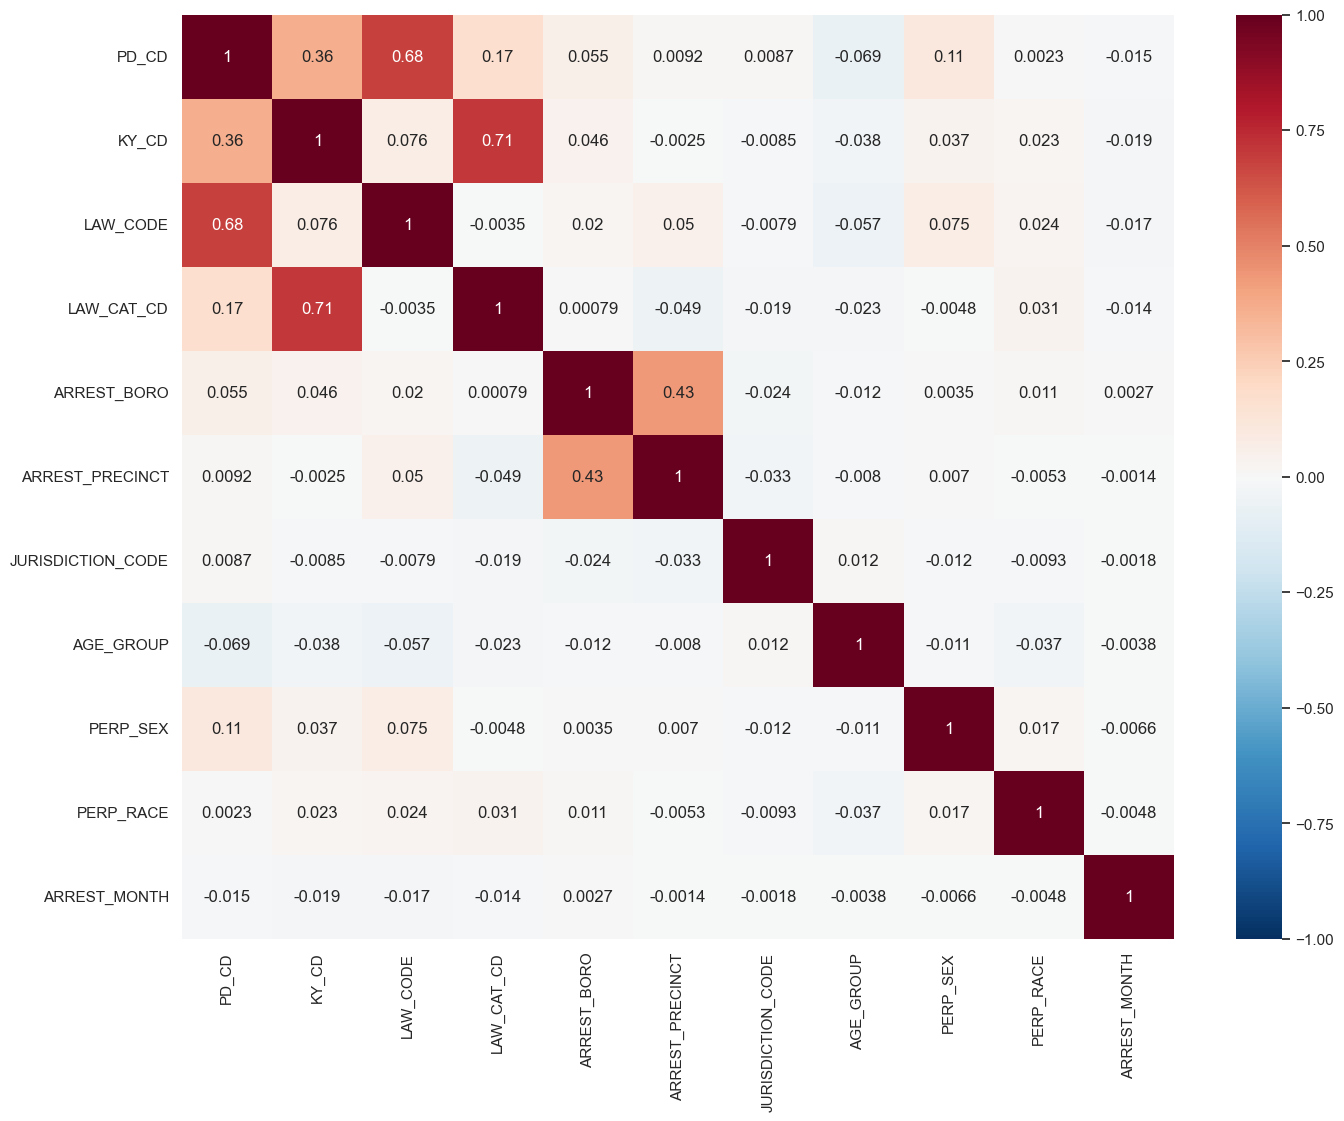

In [30]:
display(HTML("<style>.container { width:100% !important; }</style>"))
corr = arrests.corr(method='pearson')
sns.set(font_scale=1)
plt.figure(figsize=(16,12))
sns_plot = sns.heatmap(
    corr,        
    cmap='RdBu_r', 
    annot=True, 
    vmin=-1, vmax=1);

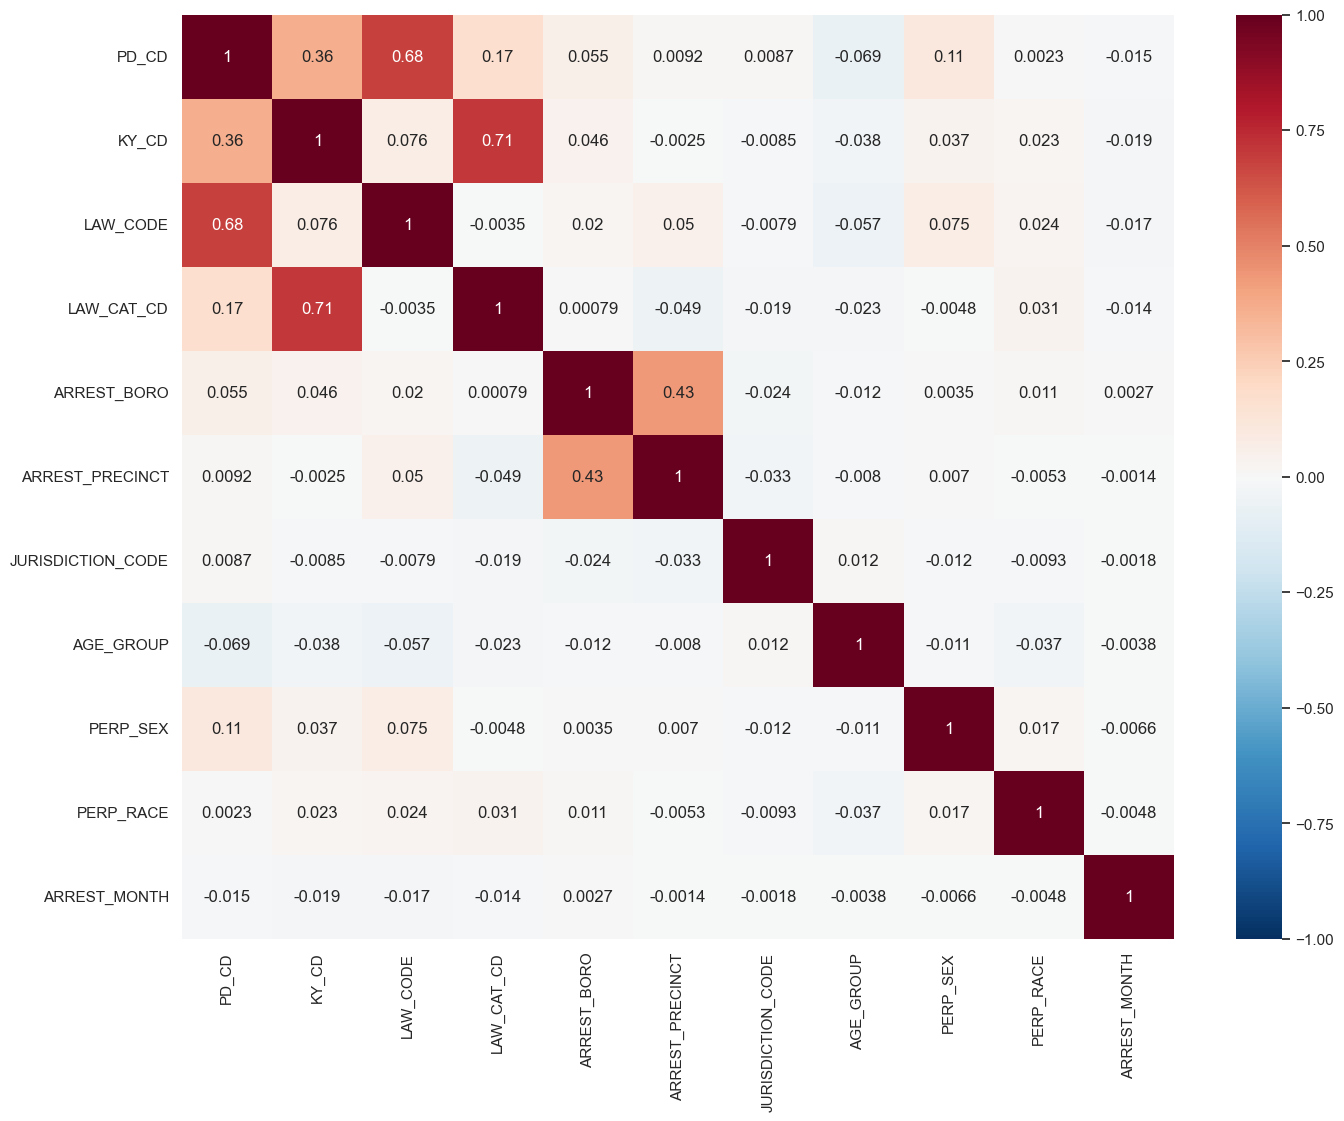

In [31]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
corr = arrests.corr(method='pearson')
sns.set(font_scale=1)
plt.figure(figsize=(16,12))
sns_plot = sns.heatmap(
    corr,        
    cmap='RdBu_r', 
    annot=True, 
    vmin=-1, vmax=1);

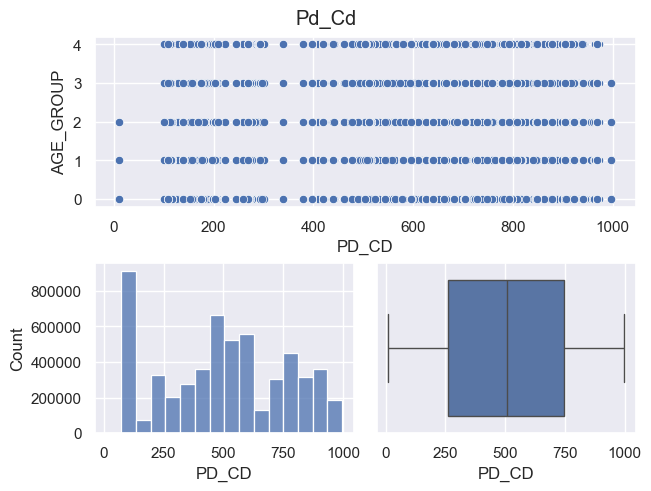

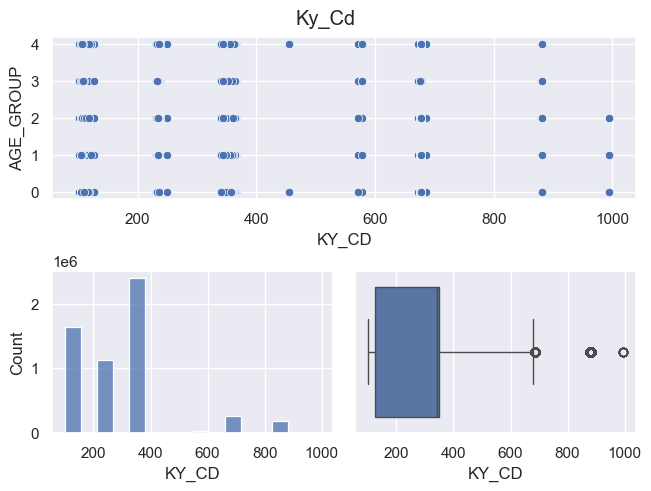

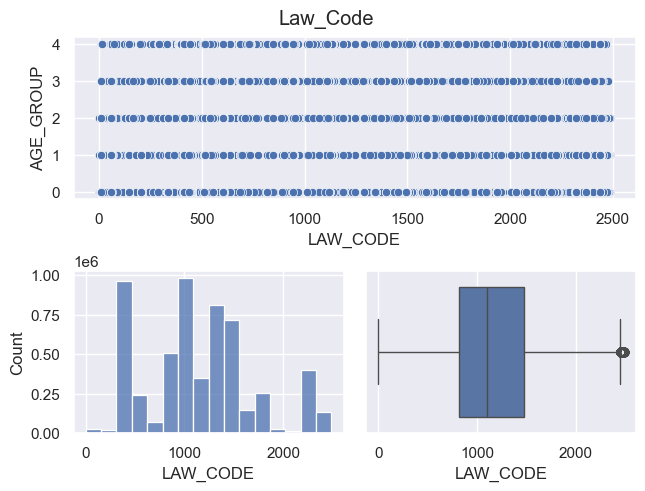

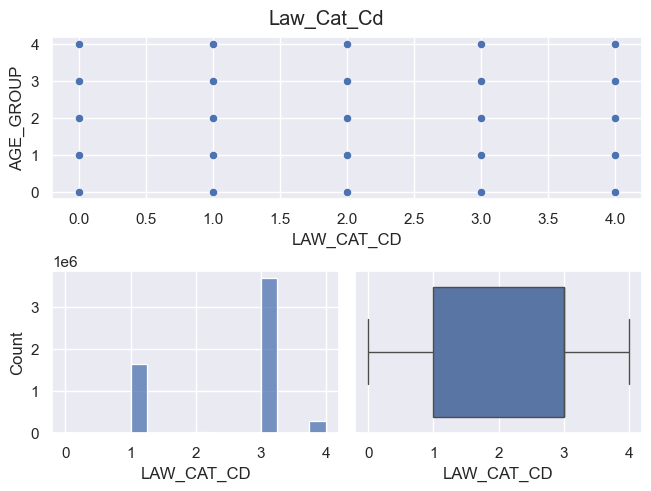

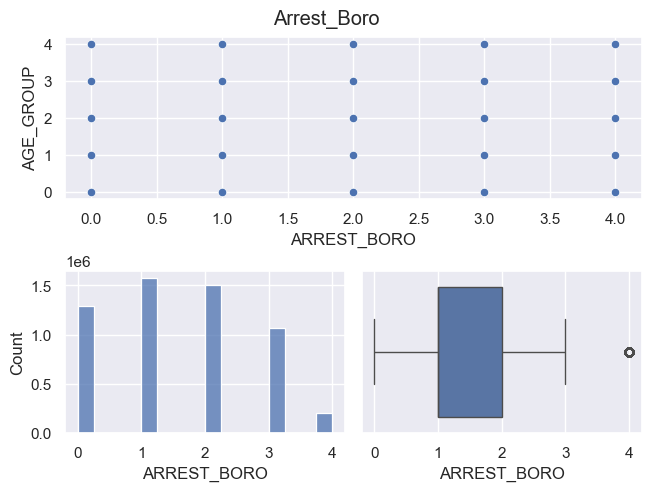

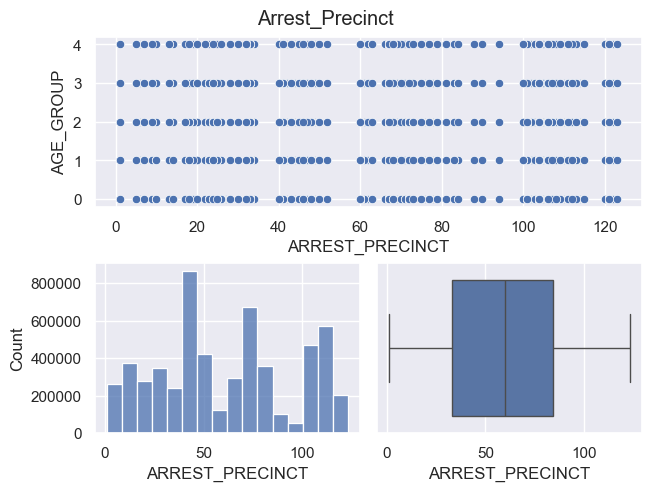

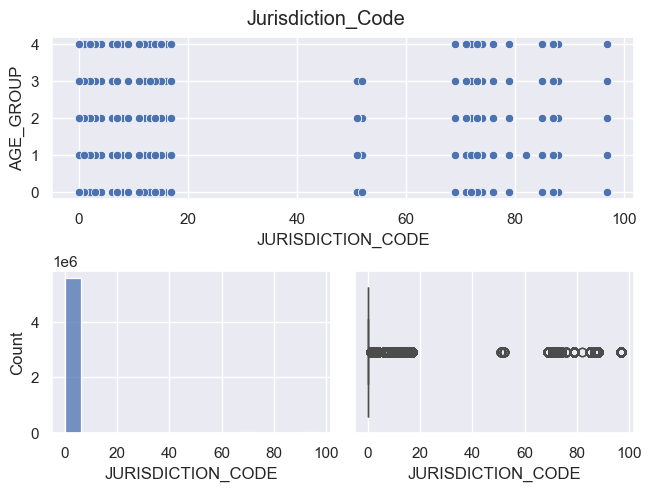

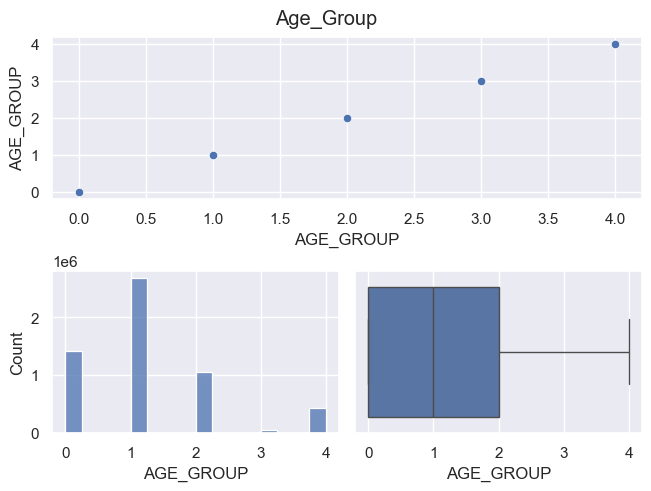

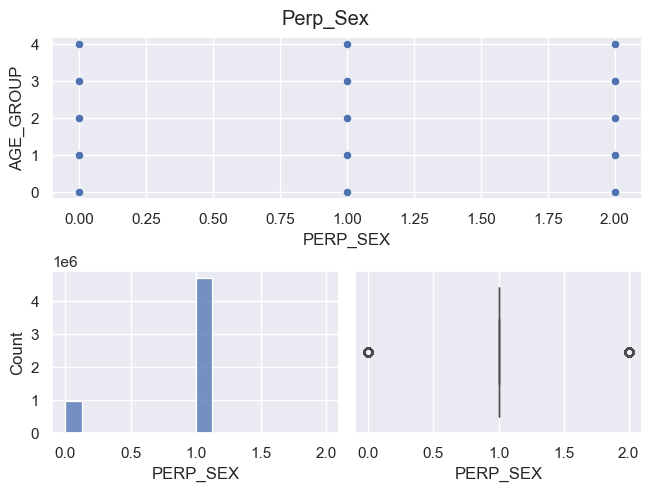

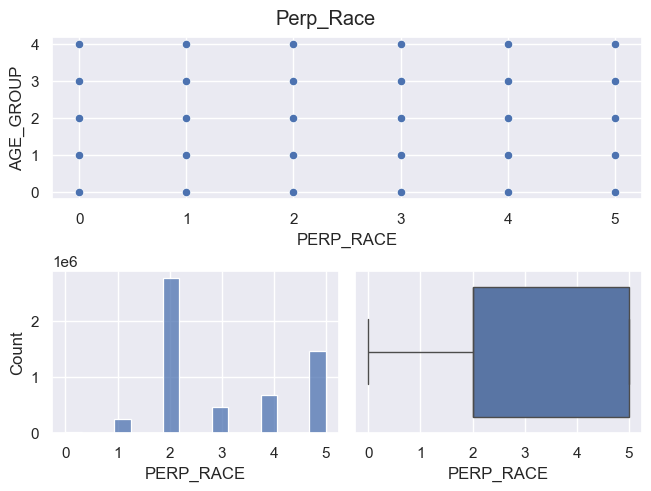

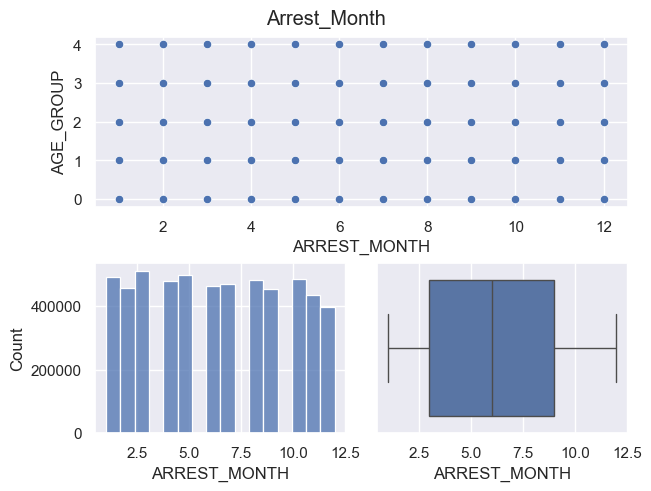

In [32]:
columns = arrests.columns
for idx in range(len(columns)):
    x_value = columns[idx]
    t_value = columns[idx].title()
    fig = plt.figure(constrained_layout=True)
    gs = GridSpec(2, 2, figure=fig)
    # create sub plots as grid
    ax1 = fig.add_subplot(gs[0, :])
    sns.scatterplot(data=arrests,x=x_value, y='AGE_GROUP')
    ax2 = fig.add_subplot(gs[1, 0])
    sns.histplot(x=x_value,data=arrests,bins=16)
    ax3 = fig.add_subplot(gs[1, 1])
    sns.boxplot(data=arrests,x=x_value,orient='h')
 
    # depict illustration
    fig.suptitle(t_value)
    print('\n')

In [33]:
arrests["AGE_GROUP"].describe()

count    5.636123e+06
mean     1.182219e+00
std      1.065890e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      4.000000e+00
Name: AGE_GROUP, dtype: float64